In [ ]:
!pip install pytesseract

In [ ]:
import cv2 # opencv
import numpy as np
import matplotlib.pyplot as plt #시각화
import pytesseract # 글자인식
plt.style.use('dark_background')
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
file_url="https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=172"


249 353 3


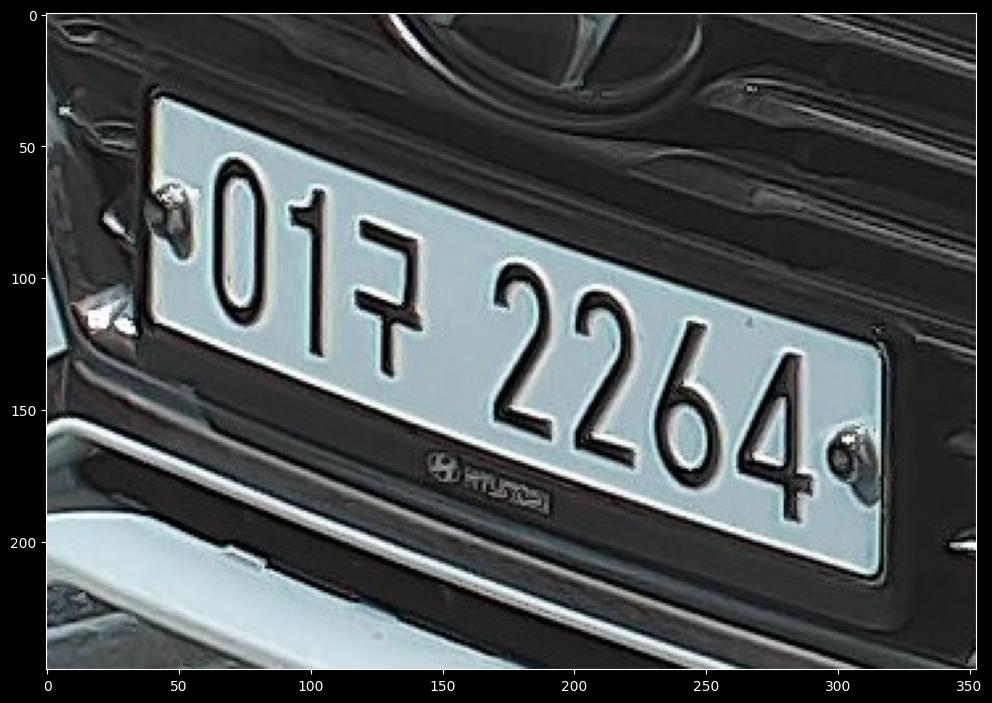

In [ ]:
file_path='/content/gdrive/My Drive/Image_Processing/01구2264-2.jpg'
label='01구2264'
def get_origin(file_path):
  img_ori = cv2.imread(file_path)

  height, width, channel = img_ori.shape

  plt.figure(figsize=(12, 10))
  plt.imshow(img_ori,cmap='gray')
  print(height, width, channel)
  return height, width, channel, img_ori

height, width, channel, img_ori=get_origin(file_path)

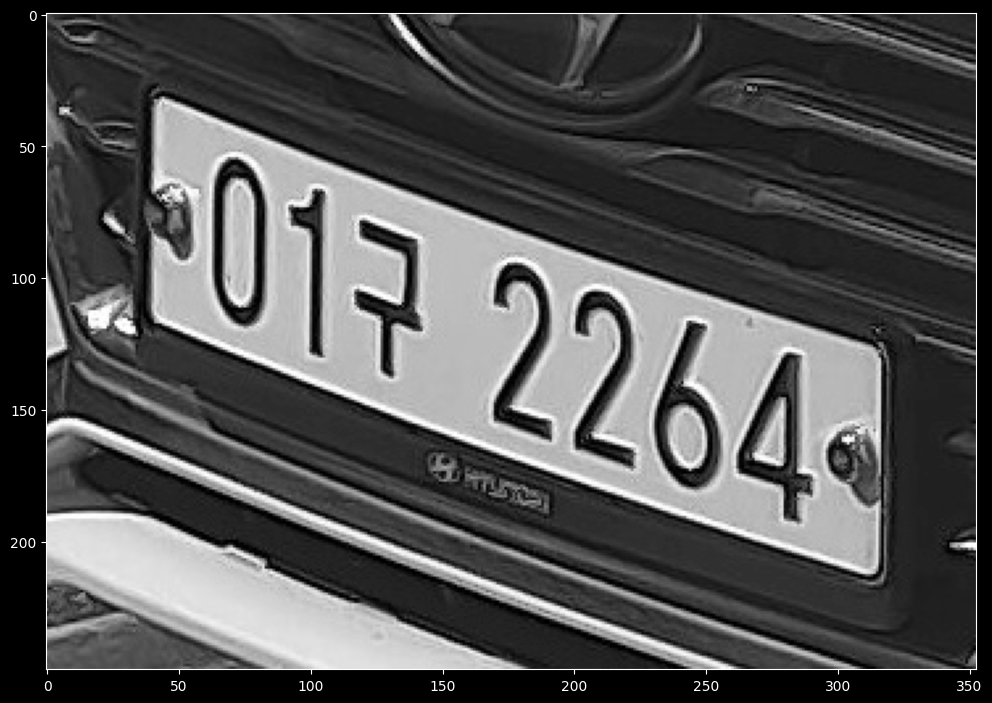

In [ ]:
def to_gray(img_ori):
  # 회색으로 변환
  gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY) # hsv
  # gray = hsv[:, :, 2]
  plt.figure(figsize=(12,10))
  plt.imshow(gray, cmap='gray')
  return gray

gray=to_gray(img_ori)

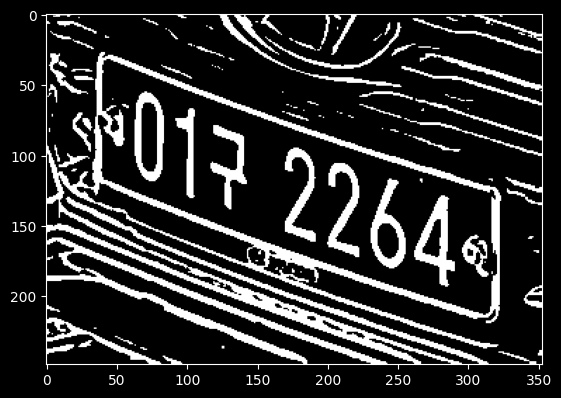

In [ ]:
def del_noise(gray):
  # 가우시안 블러=노이즈 삭제
  img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
  # thresjolding
  img_blur_thresh = cv2.adaptiveThreshold(
      img_blurred,
      maxValue=255.0,
      adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      thresholdType=cv2.THRESH_BINARY_INV,
      blockSize=19,
      C=9
  )
  plt.imshow(img_blur_thresh, cmap='gray')
  return img_blur_thresh

img_blur_thresh=del_noise(gray)

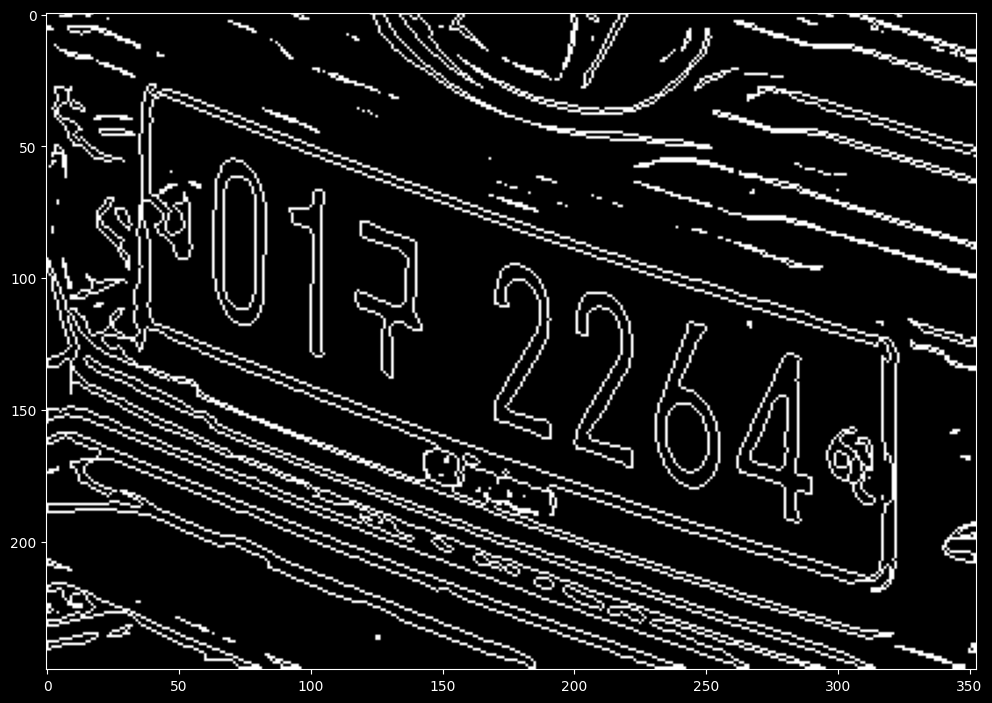

In [ ]:
def find_contours(img_blur_thresh,height,width,channel):
  # contours: 동일한 색과 강도를 가진 경계선을 연결한 선
  contours, _ = cv2.findContours(
      img_blur_thresh,
      mode=cv2.RETR_LIST,
      method=cv2.CHAIN_APPROX_SIMPLE
  )

  temp_result = np.zeros((height, width, channel), dtype=np.uint8)

  cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

  plt.figure(figsize=(12, 10))
  plt.imshow(temp_result)
  return contours

contours=find_contours(img_blur_thresh,height,width,channel)

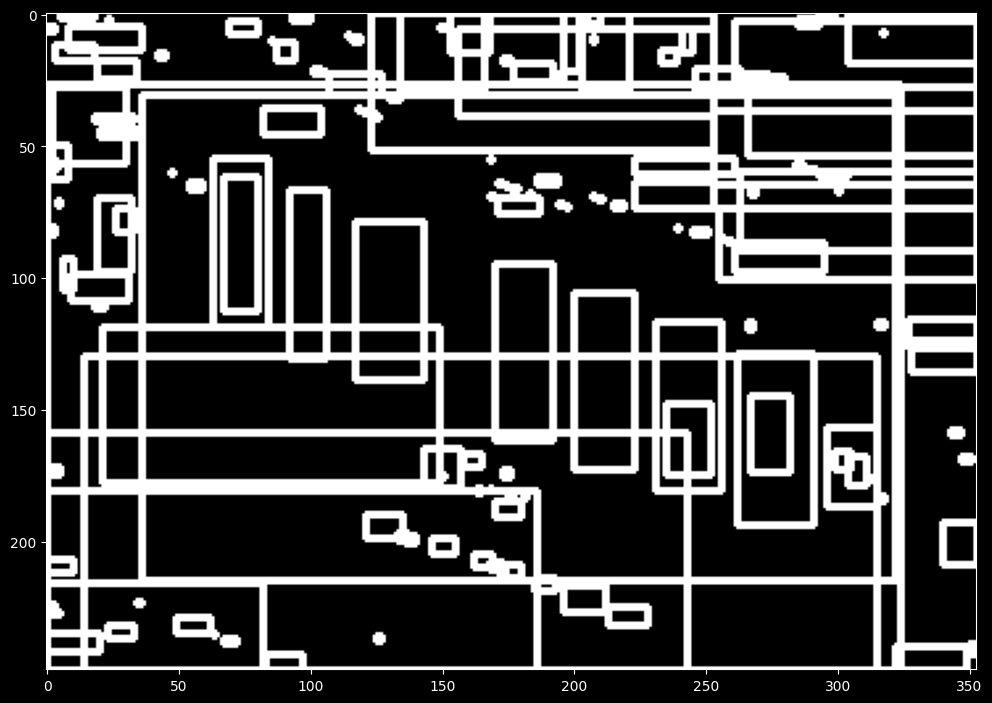

In [ ]:
def find_rectangle(contours):
  temp_result = np.zeros((height, width, channel), dtype=np.uint8) # 이미지와 동일한 크기 빈 공간

  contours_dict = [] # 각 contours의 위치정보 저장

  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

      contours_dict.append({
          'contour': contour,
          'x': x,
          'y': y,
          'w': w,
          'h': h,
          'cx': x + (w / 2),
          'cy': y + (h / 2)
      })

  plt.figure(figsize=(12,10))
  plt.imshow(temp_result, cmap='gray')
  return contours_dict

contours_dict=find_rectangle(contours)

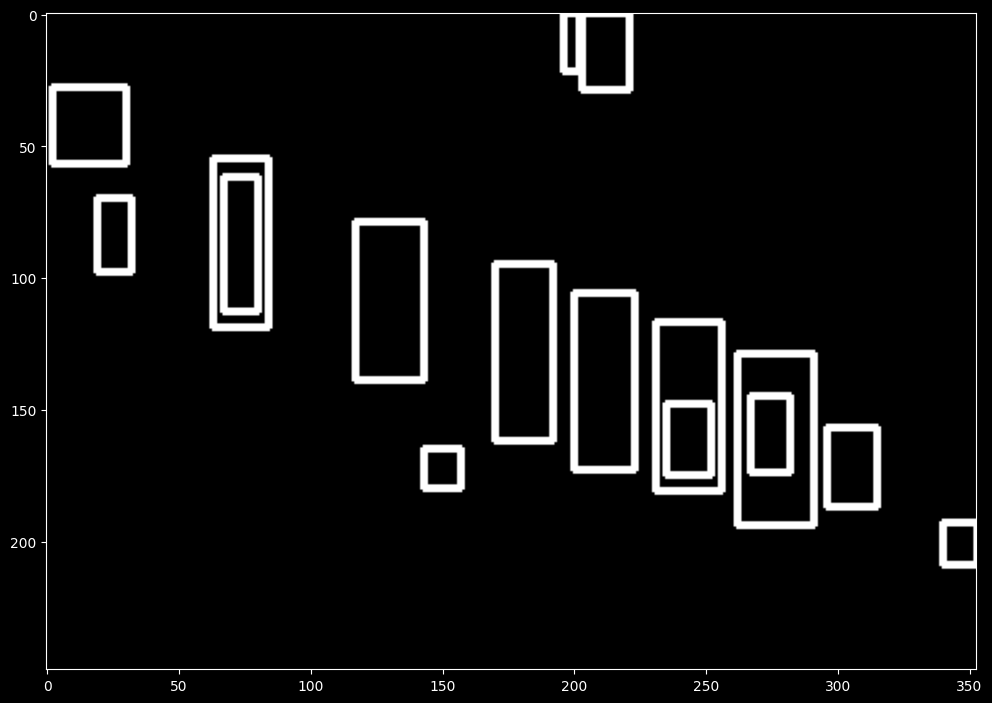

In [ ]:
def filter_ratio(contours_dict):
  # 일정 비율을 가지고 있는 번호판 숫자의 특성을 이용해 추려낸다.

  MIN_AREA = 80
  MIN_WIDTH, MIN_HEIGHT=2, 8
  MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 최소비율, 최대비율

  possible_contours = []

  cnt = 0
  for d in contours_dict:
      area = d['w'] * d['h']
      ratio = d['w'] / d['h'] # 너비와 높이로 비율을 구한다.

      if area > MIN_AREA \
      and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
      and MIN_RATIO < ratio < MAX_RATIO:
          d['idx'] = cnt
          cnt += 1
          possible_contours.append(d)

  temp_result = np.zeros((height, width, channel), dtype = np.uint8)

  for d in possible_contours:
      cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

  plt.figure(figsize=(12, 10))
  plt.imshow(temp_result, cmap='gray')
  return possible_contours

possible_contours=filter_ratio(contours_dict)

In [ ]:
def rotate_img(img_ori,ROTATE):
  print(ROTATE)
  from google.colab.patches import cv2_imshow
  rows,cols=img_ori.shape[:2]
  M=cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),ROTATE,1)
  output_img=cv2.warpAffine(img_ori,M,(cols*1,rows*1),flags=cv2.INTER_LINEAR)
  cv2_imshow(output_img)
  img_ori=output_img
  return img_ori

In [ ]:
angles=[]# 기울었는지 판단할 공간

def find_chars(contour_list):
    matched_result_idx = [] # 조건에 맞는 인덱스를 뽑아올 공간


    for d1 in contour_list:
        matched_contours_idx = [] #

        for d2 in contour_list:
            if d1['idx'] == d2['idx']:# 같은 사각형은 그대로 패스
                continue

            dx = abs(d1['cx'] - d2['cx']) # 각 사각형의 중앙선끼리 차이
            dy = abs(d1['cy'] - d2['cy']) # 각 사각형의 중앙 높이끼리 차이

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # 대각선 방향

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0: # 세로로 존재한다.
                angle_diff = 90 # 누운 사진이다.
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # 높이차이/너비차이의 역탄젠트를 하면 각도가 나온다.
                # 휘어진 사진이다.
                angles.append(angle_diff) ## 숫자가 더 많이 잡혔다는 가정하에, 모든 사각형의 기울기를 angles에 추가하면, 많은 숫자가 사진이 얼마나 기울어졌는지 찾을 수 있다.


            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) # 넓이차이
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비차 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이차 비율

            # 조건 검사
            # 번호판 Contours의 width와 height의 비율은 모두 동일하거나 비슷하다.
            # 번호판 Contours 사이의 간격은 일정하다.
            # 최소 3개 이상 Contours가 인접해 있어야한다. (대한민국 기준)
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)# 조건에 맞지 않은 사각형의 정보를 인덱스로 가지고 온다.

        recursive_contour_list = find_chars(unmatched_contour)# 재귀. 또 찾아온다.

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx # 조건에 맞는 데이터 인덱스만 가지고 온다./ 최빈값 각도를 가지고 온다.

In [ ]:
# MAX_DIAG_MULTIPLYER = 5
# MAX_ANGLE_DIFF = 12.0
# MAX_AREA_DIFF = 0.5
# MAX_WIDTH_DIFF = 0.8
# MAX_HEIGHT_DIFF = 0.2
# MIN_N_MATCHED = 3
# def filter_number(possible_contours,img_ori):
#   result_idx, angles = find_chars(possible_contours)
#   print(angles) # ex) ModeResult(mode=19, count=6)
#   # 사진이 기울어져 있는지 확인
#   if angles[0]>5 or angles[0]<-5:
#     height, width, channel, img_ori=get_origin(file_path)
#     img_ori=rotate_img(img_ori,angles[0])
#     print(img_ori.shape)
#     gray=to_gray(img_ori) # 회색으로
#     img_blur_thresh=del_noise(gray) # 노이즈 삭제
#     contours=find_contours(img_blur_thresh,height,width,channel) # 컨투어(닫힌선) 찾기
#     contours_dict=find_rectangle(contours) # 사각형으로 표현
#     possible_contours=filter_ratio(contours_dict) # 비율 맞는 사각형 그리기
#     result_idx, _ = find_chars(possible_contours) # angles는 더 쓰지 않음

#   matched_result = []
#   for idx_list in result_idx:
#     matched_result.append(np.take(possible_contours, idx_list)) # 조건에 맞는 데이터만 가지고 온다.

#   temp_result = np.zeros((height, width, channel), dtype=np.uint8)

#   for r in matched_result: # 맞는 데이터만 저장됨.
#     for d in r:
#       cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

#   plt.figure(figsize=(12, 10))
#   plt.imshow(temp_result, cmap='gray')
#   return matched_result

# matched_result=filter_number(possible_contours,img_ori)

[[2, 4, 3]]
ModeResult(mode=20, count=30)
249 353 3
20


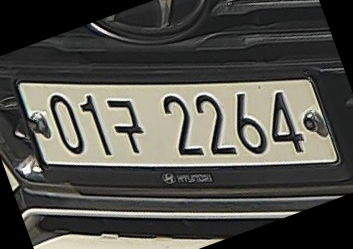

(249, 353, 3)
[[0, 3, 2], [4, 6, 7, 8, 9, 10, 11, 5]]


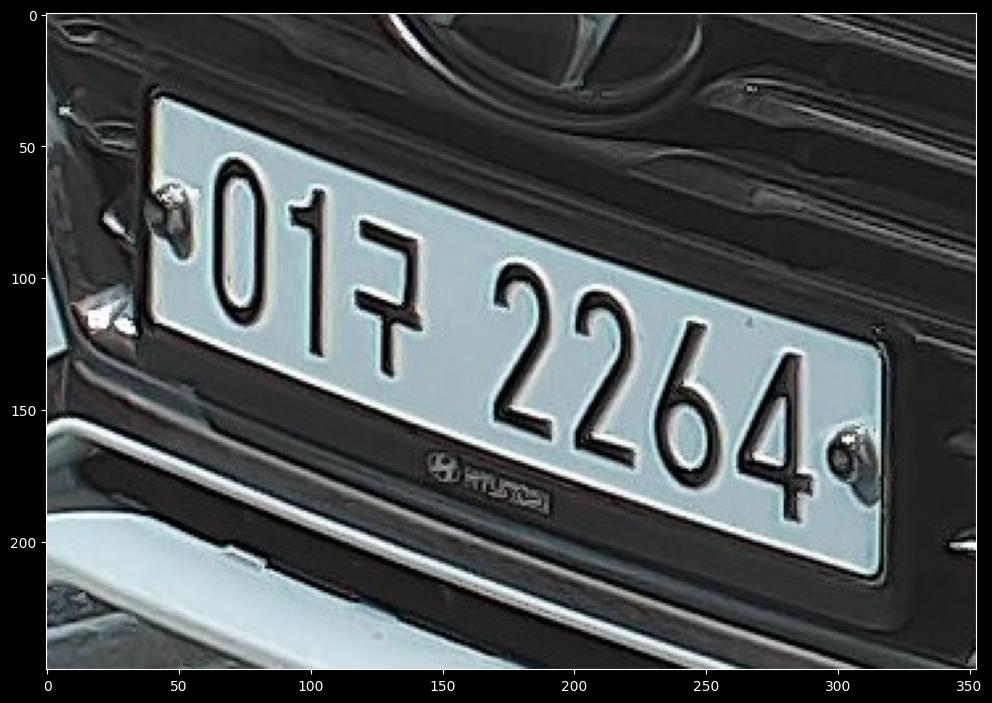

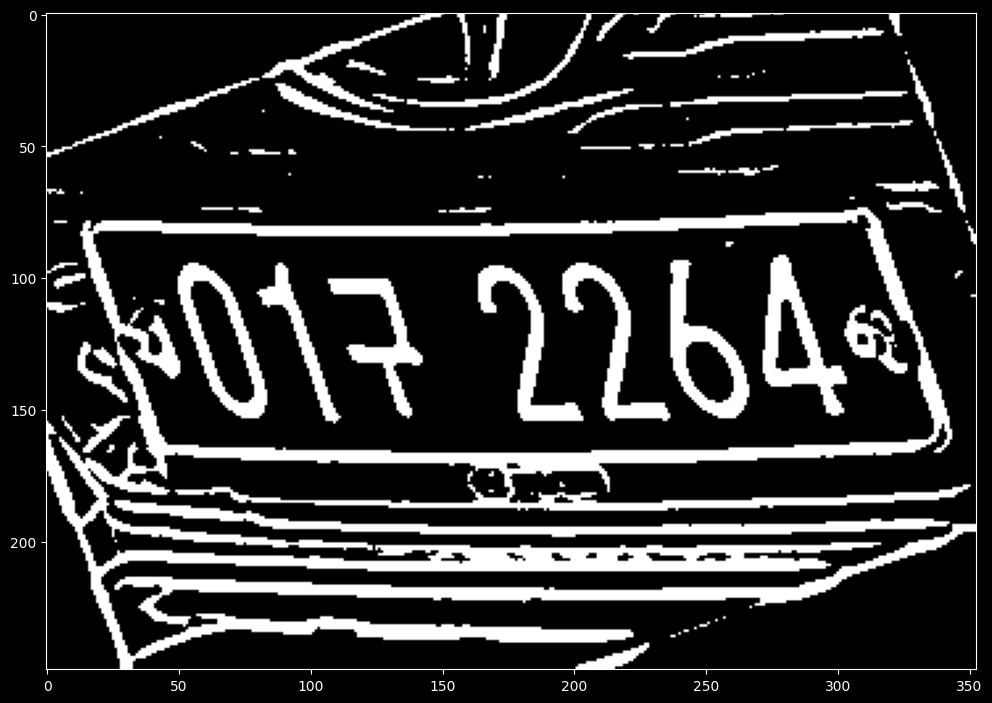

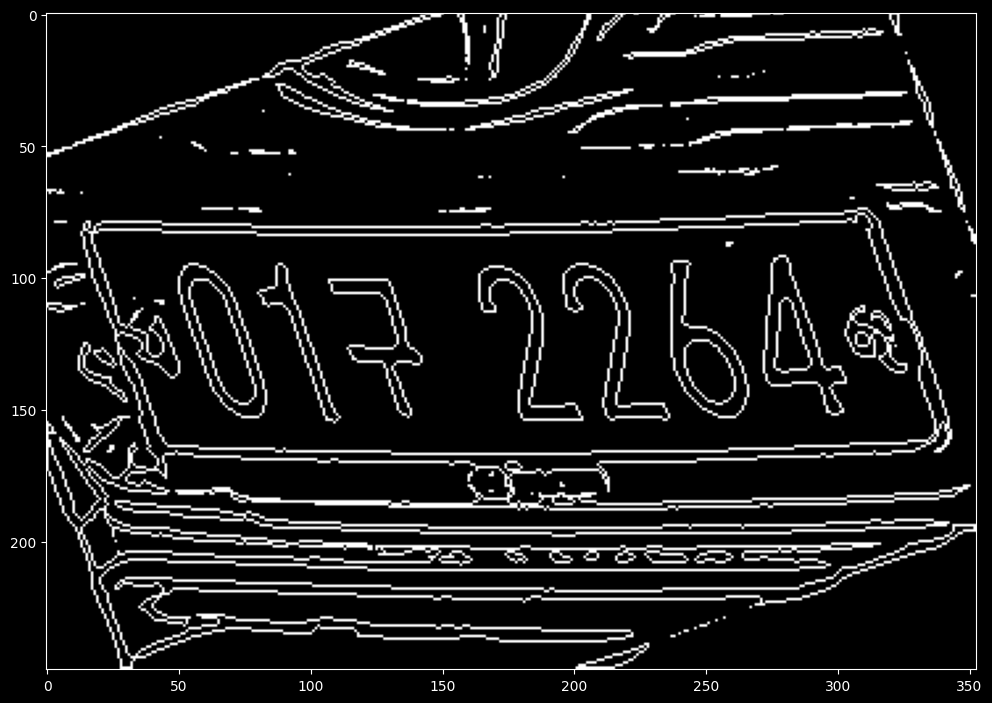

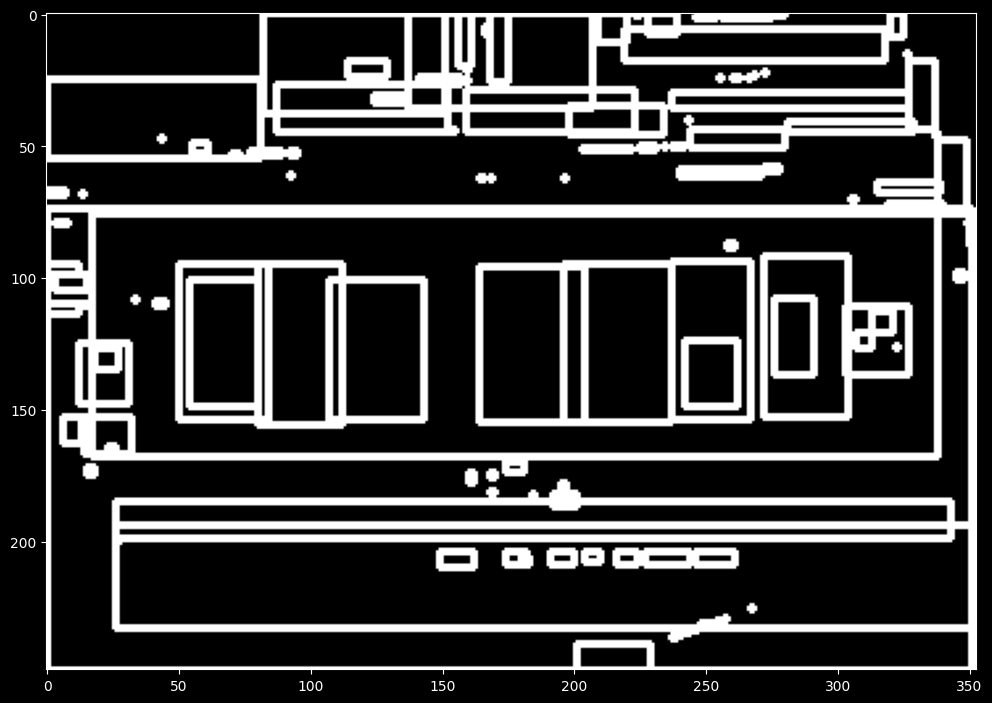

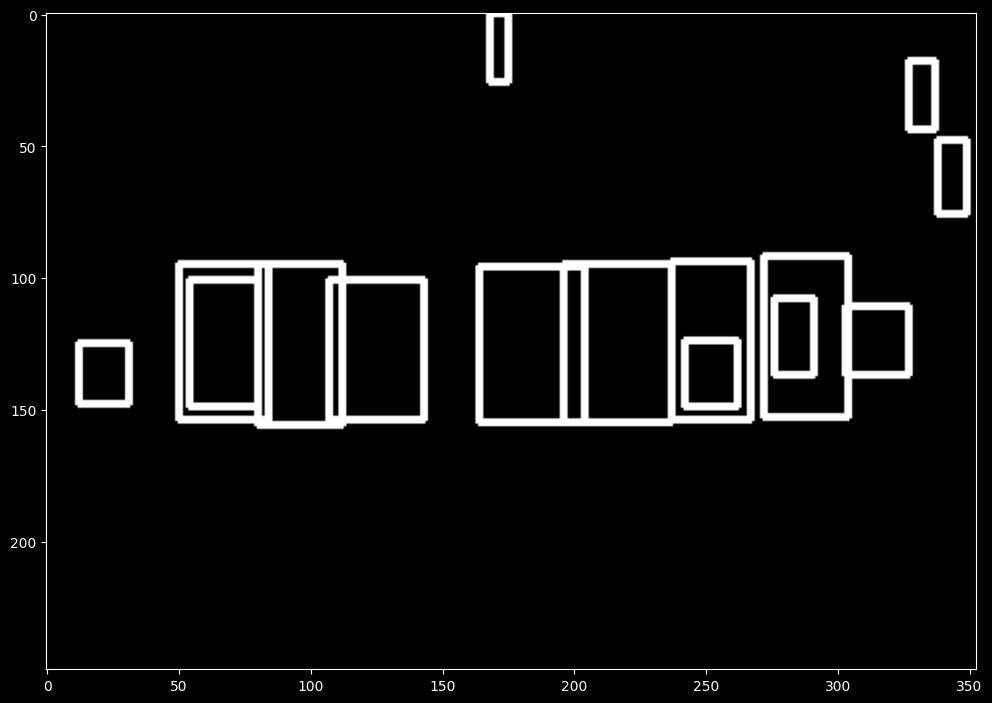

In [ ]:
from scipy.stats import mode

MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

result_idx = find_chars(possible_contours)

angle= mode(list(map(int,angles))) # 각도 최빈값으로 가져옴.
print(result_idx)
print(angle)# ex) ModeResult(mode=19, count=6)

# 사진이 기울어져 있는지 확인
height, width, channel, img_ori=get_origin(file_path)
if angle[0]>5 or angle[0]<-5:
  img_ori=rotate_img(img_ori,angle[0])
  print(img_ori.shape)
  gray=to_gray(img_ori) # 회색으로
  img_blur_thresh=del_noise(gray) # 노이즈 삭제
  contours=find_contours(img_blur_thresh,height,width,channel) # 컨투어(닫힌선) 찾기
  contours_dict=find_rectangle(contours) # 사각형으로 표현
  possible_contours=filter_ratio(contours_dict) # 비율 맞는 사각형 그리기
  result_idx = find_chars(possible_contours) # 이미 기울기를 제거 했으므로, angles는 더 쓰지 않음

print(result_idx)

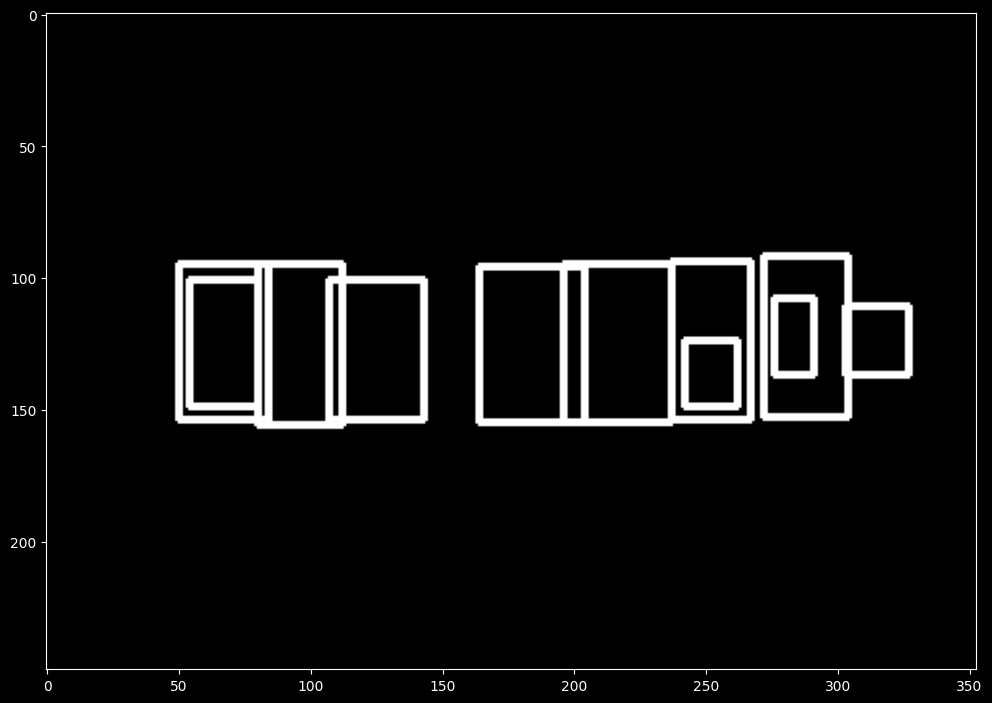

In [ ]:
matched_result = []
for idx_list in result_idx:
  matched_result.append(np.take(possible_contours, idx_list)) # 조건에 맞는 데이터만 가지고 온다.

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result: # 맞는 데이터만 저장됨.
  for d in r:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')



In [ ]:
matched=matched_result[1] # 0: 작은거, 1: 큰거
print(len(matched))
print(len(matched_result[0]))

8
3


In [ ]:
def make_json(file_url,height,width,i, file_name,file_size,label):
  import datetime

  dt=datetime.datetime.today()

  date=dt.strftime("%Y-%m-%d")

  json={
    "original_img":
    {
      "file_url":file_url,
      "file_path":file_path,
      "date":date,
      "C_name":"남인경",
      "original_size":[height, width]
    },
    "label_info":
    {
      "U_ID":"AA_000000"+str(i),
      "label_path":file_name,
      "label_num":label,
      "label_size":list(file_size)
    }
  }
  return json

In [ ]:
m=matched_result[0]
img.crop((m['x'],m['y'],m['x']+m['w'], m['y']+m['h']))

plt.imshow(cropped)

IndexError: ignored

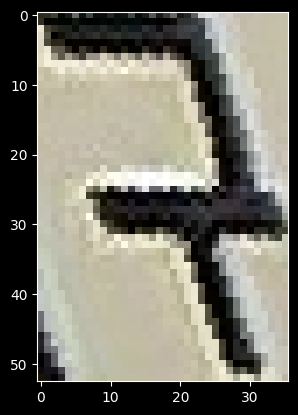

In [ ]:
# 분할된 이미지로 자르기
from PIL import Image
import json
i=10
for m in matched:
  img=Image.open(file_path)
  img=img.rotate(angle[0])
  cropped=img.crop((m['x'],m['y'],m['x']+m['w'], m['y']+m['h']))

  plt.imshow(cropped)

  # file_size=cropped.size
  # file_name=f'/content/gdrive/My Drive/Image_Processing/car/car2_{i}.jpg'
  # print(i)
  # c=i%10
  # print(c)
  # w=label[c]
  # print(type(w))
  # json_string = json.dumps(make_json(file_url,height,width,i, file_name,file_size,w))

  # cropped.save(file_name)
  # with open(f'/content/gdrive/My Drive/Image_Processing/car/car2_{i}.json','w',encoding='utf-8') as make_file:
  #   make_file.write(json_string)
  i+=1

In [ ]:
label[12%10]

'구'